In [579]:
from typing import Callable
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

class MIT:
    def __init__(self):
        pass

    def multiview_iteration(self, df_t:pd.DataFrame, max_iter:int=100, household_idx:int=1):
        """
        should be
        df.columns = ["Energy", "Time", "Occupancy"]
        """
        # line1
        df_t = self._prior(df_t, household_idx)
        df_t["preds_t"] = df_t["preds_time"]
        tmp = df_t

        stop_condition = False
        t = 1
        eta_t = 0.5
        print("line1 completed")

        while (not stop_condition)&(t < max_iter):
            df_new = pd.DataFrame()

            # line2-5
            model_energy = DecisionTreeClassifier(max_depth=3)
            model_energy.fit(df_t.Energy.values.reshape(-1, 1), df_t.preds_t.values.reshape(-1, 1))
            df_t["preds_energy"] = model_energy.predict(df_t.Energy.values.reshape(-1, 1))
            print("line2-5 completed")

            # line6
            df_t["preds_majority_vote"] = df_t.preds_energy | df_t.preds_t
            print("line6 completed")

            # line 7
            df_new = df_t[df_t.preds_t != df_t.preds_majority_vote]
            df_new["preds_new"] = df_new.preds_majority_vote
            print("line7 completed")

            # line 8
            df_tplus1 = df_t[df_t.preds_t == df_t.preds_majority_vote]
            synmetric_diff_sample_df = self._synmetric_diff_sample(df_t)
            df_tplus1 = pd.concat([df_tplus1, synmetric_diff_sample_df], axis=0)
            print("line8 completed")

            # line 9
            df_t["preds_t"] = df_t["preds_majority_vote"]
            eta_tplus1 = self._est_eta(df_tplus1)
            stop_condition = self._check_if_stop(df_t, df_tplus1, eta_tplus1, eta_t)
            df_t = df_tplus1
            eta_t = eta_tplus1
            t += 1
            print("line9 completed")
        print("algo completed")
        return df_t, tmp

    def _prior(self, df, household_idx=1):
        if household_idx in [2]:
            preds_time = []
            for _, row in df.iterrows():
                if (row.Time >= 18) & (row.Time <= 40):
                    preds_time.append(0)
                else:
                    preds_time.append(1)
            df["preds_time"] = preds_time
        elif household_idx in [1, 3]:
            preds_time = []
            for _, row in df.iterrows():
                if (row["Time"] >= 24) & (row["Time"] <= 28):
                    preds_time.append(0)
                else:
                    preds_time.append(1)
            df["preds_time"] = preds_time
        return df
    def _synmetric_diff_sample(self, df_old, alpha_0=0.5, alpha_1=0.5):
        synmetric_diff = pd.DataFrame()
        synmetric_diff = df_old[df_old.preds_t != df_old.preds_majority_vote]
        df_len = synmetric_diff.shape[0]
        print(df_len)
        
        synmetric_diff_sammple_0 = synmetric_diff[synmetric_diff.preds_majority_vote == False]
        synmetric_diff_sammple_1 = synmetric_diff[synmetric_diff.preds_majority_vote == True]
        
        synmetric_diff_sammple_0 = synmetric_diff_sammple_0.sample(int(synmetric_diff_sammple_0.shape[0]*alpha_0))
        synmetric_diff_sammple_1 = synmetric_diff_sammple_1.sample(int(synmetric_diff_sammple_1.shape[0]*alpha_1))
        return pd.concat([synmetric_diff_sammple_0, synmetric_diff_sammple_1], axis=0)

    def _est_eta(self, df):
        num = sum((df.preds_t==1)&(df.preds_majority_vote==0)) + sum((df.preds_t==0)&(df.preds_majority_vote==1))
        det = df.shape[0]
        return num/det
    
    def _check_if_stop(self, df_t, df_tplus1, eta_tplus1, eta_t):
        return df_tplus1.shape[0]*(1-2*eta_tplus1) > df_t.shape[0]*(1-2*eta_t)

In [580]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [581]:
target_idx = 3
summer_idx = 0

In [582]:
target_X = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_X_train.csv")
target_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{target_idx}_Y_train.csv")[target_X.Season==summer_idx]
target_X = target_X[target_X.Season==summer_idx]

In [583]:
mit = MIT()

In [584]:
target_X

,Energy,Season,Time
1504,67363.495,0,12
1505,237118.680,0,13
1506,78601.300,0,14
1507,274467.298,0,15
1508,492557.058,0,16
...,...,...,...
2075,504342.309,0,39
2076,596620.374,0,40
2077,478971.234,0,41
2078,589670.944,0,42


In [585]:
target_y_task

,Occupancy
1504,1
1505,1
1506,1
1507,1
1508,1
...,...
2075,1
2076,1
2077,1
2078,1


In [586]:
df = pd.concat([target_X, target_y_task], axis=1).drop(columns="Season")
df, tmp  = mit.multiview_iteration(df, max_iter=100, household_idx=target_idx)

line1 completed
line2-5 completed
line6 completed
line7 completed
88
line8 completed
line9 completed
algo completed


<ipython-input-579-6a55d6537dce>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["preds_new"] = df_new.preds_majority_vote


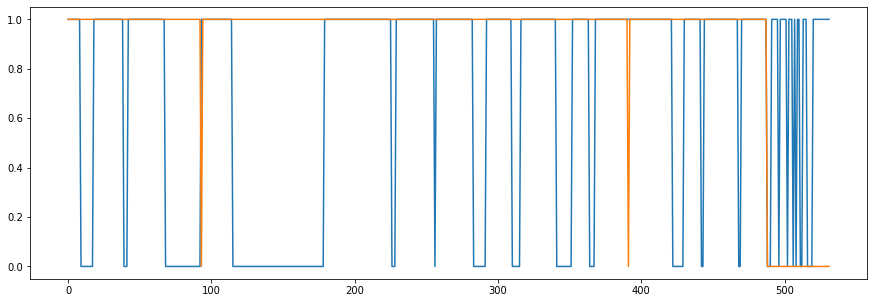

In [587]:
plt.figure(figsize=(15, 5))
plt.plot(df["Occupancy"].values)
plt.plot(df["preds_t"].values)

In [588]:
sum(df["Occupancy"] == df["preds_t"])/df.shape[0]

0.6616541353383458

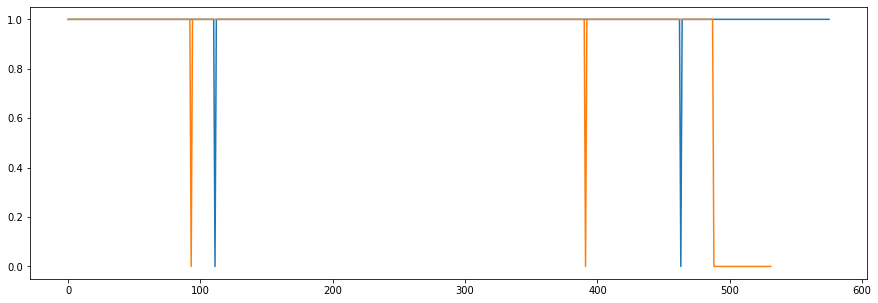

In [589]:
plt.figure(figsize=(15, 5))
plt.plot(tmp["preds_t"].values)
plt.plot(df["preds_t"].values)